In [430]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import IPython
import IPython.display

import tensorflow as tf
from keras.layers import Dense, LSTM, Lambda
import xgboost as xgb

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# sklearn config
from sklearn import set_config
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error

# SƠ LƯỢC DỮ LIỆU

In [431]:
header = ['date', 'KLGD', 'GTGD', 'capital', 'close_price', 'daily_return','daily_return_pct', 'KL', 'GT']
column_range = list(range(9))
df = pd.read_csv("data\MWG-20230414-1418.csv", skiprows= 8 ,index_col=0, header= None, usecols=column_range).reset_index() # Data for local invest
df.columns = header
# df = pd.read_csv("data\MWG.csv", index_col=0).reset_index()
print(f"Dữ liệu bao gồm {df.shape[0]} dòng và {df.shape[1]} cột:")
print ('Mẫu bảng dữ liệu :\n')
df.head()

Dữ liệu bao gồm 252 dòng và 9 cột:
Mẫu bảng dữ liệu :



,date,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT
0,14/04/2023,"1,710,500","69,878","59,633","40,750",-300,-0.73,"1,710,500","69,878"
1,13/04/2023,"3,716,000","153,698","60,072","41,050",300,0.74,"3,135,000","128,411"
2,12/04/2023,"5,666,500","236,849","59,633","40,750",50,0.12,"3,970,800","163,086"
3,11/04/2023,"5,749,500","242,682","59,559","40,700",-300,-0.73,"2,852,300","115,640"
4,10/04/2023,"10,616,296","436,606","59,998","41,000","2,000",5.13,"5,829,400","236,992"


In [432]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              252 non-null    object 
 1   KLGD              252 non-null    object 
 2   GTGD              252 non-null    object 
 3   capital           252 non-null    object 
 4   close_price       252 non-null    object 
 5   daily_return      239 non-null    object 
 6   daily_return_pct  239 non-null    float64
 7   KL                252 non-null    object 
 8   GT                252 non-null    object 
dtypes: float64(1), object(8)
memory usage: 17.8+ KB


In [433]:
df.describe()

,daily_return_pct
count,239.000000
mean,-0.227029
std,2.918594
min,-7.000000
25%,-1.625000
50%,-0.150000
75%,1.365000
max,6.990000


Rename columns

Feature engineer with date time

In [434]:
# Convert the date column to a pandas datetime object
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df = df.sort_values(by='date', ascending=True, ignore_index = True)

In [435]:
def convert_type(dataframe):
    dataframe = dataframe.fillna(0)
    for col in dataframe.columns:
        if col == 'date':
            continue
        else:
            dataframe[col] = dataframe[col].apply(
                lambda x: float(str(x).replace(',', '').replace('-', '0'))
                if isinstance(x, str) and x.strip() != ''
                else (np.nan if isinstance(x, str) and x.strip() == '' else x)
            )
    return dataframe
df = convert_type(df)

In [436]:
df.head()

,date,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT
0,2022-04-14,2992800.0,477771.0,116758.0,159500.0,3300.0,2.11,2925900.0,467335.0
1,2022-04-15,2959800.0,480101.0,117270.0,160200.0,700.0,0.44,2339800.0,374329.0
2,2022-04-18,2933800.0,474702.0,117270.0,160200.0,0.0,0.00,2616900.0,420385.0
3,2022-04-19,4081200.0,656706.0,114196.0,156000.0,4200.0,-2.62,3285000.0,520237.0
4,2022-04-20,2200700.0,346491.0,114196.0,156000.0,0.0,0.00,1900700.0,296421.0


# PREPROCESSING

MA price

In [437]:
# The MA for close price
ma_day = [10, 20]
for ma in ma_day:
    column_name = f"MA{ma}"
    df[column_name] = df['close_price'].rolling(ma).mean()
    df[f"close_MA{ma}"] = df["close_price"] - df[column_name]

In [438]:
# The MA for volumne
ma_vol = 20
column_name = f"MA{ma_vol}_vol"
df[column_name] = df['KL'].rolling(ma_vol).mean()
df[f"close_MA{ma_vol}_vol"] = df["close_price"] - df[column_name]

The change of volume each day

In [439]:
df[f'Daily_Return_KL_pct'] = df['KL'].pct_change()

In [440]:
df = df.dropna()
df.tail()

,date,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT,MA10,close_MA10,MA20,close_MA20,MA20_vol,close_MA20_vol,Daily_Return_KL_pct
247,2023-04-10,10616296.0,436606.0,59998.0,41000.0,2000.0,5.13,5829400.0,236992.0,39260.0,1740.0,38920.0,2080.0,2205190.0,-2164190.0,1.868517
248,2023-04-11,5749500.0,242682.0,59559.0,40700.0,300.0,-0.73,2852300.0,115640.0,39420.0,1280.0,39025.0,1675.0,2267225.0,-2226525.0,-0.510704
249,2023-04-12,5666500.0,236849.0,59633.0,40750.0,50.0,0.12,3970800.0,163086.0,39625.0,1125.0,39062.5,1687.5,2370805.0,-2330055.0,0.392140
250,2023-04-13,3716000.0,153698.0,60072.0,41050.0,300.0,0.74,3135000.0,128411.0,39870.0,1180.0,39145.0,1905.0,2444305.0,-2403255.0,-0.210487
251,2023-04-14,1710500.0,69878.0,59633.0,40750.0,300.0,-0.73,1710500.0,69878.0,40090.0,660.0,39212.5,1537.5,2482140.0,-2441390.0,-0.454386


In [441]:
drop_cols = ['date','KLGD','GTGD', 'capital']
df.drop(columns=drop_cols, axis=1, inplace= True)

Because our data is just in 1 year, so I don't feature engineer for date. I also found it boost the performance without date encoding

Normalize data - Pipeline

In [442]:
df.reset_index(drop=True, inplace=True)

In [443]:
df.columns

Index(['close_price', 'daily_return', 'daily_return_pct', 'KL', 'GT', 'MA10',
       'close_MA10', 'MA20', 'close_MA20', 'MA20_vol', 'close_MA20_vol',
       'Daily_Return_KL_pct'],
      dtype='object')

In [444]:
df.head()

,close_price,daily_return,daily_return_pct,KL,GT,MA10,close_MA10,MA20,close_MA20,MA20_vol,close_MA20_vol,Daily_Return_KL_pct
0,125100.0,9300.0,-6.92,2746800.0,359383.0,141670.0,-16570.0,148040.0,-22940.0,2218695.0,-2093595.0,0.610460
1,123000.0,2100.0,-1.68,1334500.0,168692.0,139470.0,-16470.0,146215.0,-23215.0,2139125.0,-2016125.0,-0.514162
2,131600.0,8600.0,6.99,1055800.0,134181.0,137710.0,-6110.0,144785.0,-13185.0,2074925.0,-1943325.0,-0.208842
3,133500.0,1900.0,1.44,805600.0,105969.0,136110.0,-2610.0,143450.0,-9950.0,1984360.0,-1850860.0,-0.236977
4,133000.0,500.0,-0.37,839200.0,110730.0,134470.0,-1470.0,142300.0,-9300.0,1862070.0,-1729070.0,0.041708


In [445]:
df.describe()

,close_price,daily_return,daily_return_pct,KL,GT,MA10,close_MA10,MA20,close_MA20,MA20_vol,close_MA20_vol,Daily_Return_KL_pct
count,233.000000,233.000000,233.000000,2.330000e+02,233.000000,233.000000,233.000000,233.000000,233.000000,2.330000e+02,2.330000e+02,233.000000
mean,62087.553648,1282.618026,-0.171888,2.867535e+06,171532.557940,64034.763948,-1947.210300,66394.667382,-4307.113734,2.833471e+06,-2.771384e+06,0.140442
std,29554.971714,1526.422602,2.840170,1.603990e+06,108815.092234,30644.675841,8741.219803,32009.993264,12763.556897,8.834771e+05,8.924894e+05,0.645706
min,37700.000000,0.000000,-6.990000,5.421000e+05,34268.000000,38335.000000,-63730.000000,38840.000000,-62655.000000,1.313240e+06,-4.435790e+06,-0.733514
25%,42750.000000,300.000000,-1.520000,1.675300e+06,87019.000000,43120.000000,-2610.000000,43997.500000,-5605.000000,2.013980e+06,-3.339420e+06,-0.311165
50%,52000.000000,800.000000,-0.110000,2.550700e+06,152161.000000,56170.000000,-525.000000,57725.000000,-1797.500000,3.009200e+06,-2.957600e+06,-0.025259
75%,67100.000000,1600.000000,1.280000,3.748300e+06,235083.000000,69070.000000,1040.000000,69710.000000,1675.000000,3.404420e+06,-1.957395e+06,0.376829
max,154700.000000,10000.000000,6.990000,1.084750e+07,778223.000000,150040.000000,12340.000000,148040.000000,15930.000000,4.507490e+06,-1.163240e+06,4.206330


In [446]:
def divide_1000 (x):
    return x/1000

In [447]:
num_cols = ['close_price','daily_return', 'KL', 'GT', 'MA10', 'MA20', 'close_MA10','close_MA20', 'MA20_vol', 'close_MA20_vol'] 
other_cols = [element for element in df.columns.to_list() if (element not in num_cols)]

print (other_cols)

['daily_return_pct', 'Daily_Return_KL_pct']


In [448]:
Numerical = Pipeline(steps=[('divide_1000', FunctionTransformer(divide_1000)), ('standard scaler',StandardScaler())])
Pct_pipe = Pipeline(steps=[('standard scaler',StandardScaler())])

In [449]:
def dataframe_pipe_trans(dataframe, num_cols = num_cols, log_cols = other_cols):
    # Standardize pipe
    Numerical.fit(dataframe[num_cols])
    Numerical_df = pd.DataFrame(Numerical.transform(dataframe[num_cols]), columns=num_cols)

    # Log pipe
    Pct_pipe.fit(dataframe[log_cols])
    Pct_df = pd.DataFrame(Pct_pipe.transform(dataframe[log_cols]), columns=log_cols)

    # Combine standardized and log transformed columns
    transformed_df = pd.concat([Numerical_df, Pct_df], axis=1)
    transformed_df.reset_index(drop=True, inplace=True)

    return transformed_df
df_trans = dataframe_pipe_trans(df)
df_trans.head()

,close_price,daily_return,KL,GT,MA10,MA20,close_MA10,close_MA20,MA20_vol,close_MA20_vol,daily_return_pct,Daily_Return_KL_pct
0,2.136632,5.263708,-0.075434,1.730044,2.538855,2.556111,-1.676456,-1.462993,-0.697358,0.761071,-2.381069,0.729479
1,2.065425,0.536641,-0.957821,-0.026161,2.466909,2.498975,-1.664991,-1.484586,-0.787616,0.848060,-0.532137,-1.015963
2,2.357035,4.804132,-1.131949,-0.343996,2.409353,2.454205,-0.477251,-0.697063,-0.860440,0.929805,2.527070,-0.542099
3,2.421460,0.405334,-1.288271,-0.603820,2.357029,2.412410,-0.075987,-0.443061,-0.963171,1.033632,0.568754,-0.585764
4,2.404506,-0.513818,-1.267278,-0.559972,2.303398,2.376406,0.054711,-0.392025,-1.101888,1.170387,-0.069904,-0.153238


In [450]:
df_temp = df.copy()

In [451]:
df_trans.head()

,close_price,daily_return,KL,GT,MA10,MA20,close_MA10,close_MA20,MA20_vol,close_MA20_vol,daily_return_pct,Daily_Return_KL_pct
0,2.136632,5.263708,-0.075434,1.730044,2.538855,2.556111,-1.676456,-1.462993,-0.697358,0.761071,-2.381069,0.729479
1,2.065425,0.536641,-0.957821,-0.026161,2.466909,2.498975,-1.664991,-1.484586,-0.787616,0.848060,-0.532137,-1.015963
2,2.357035,4.804132,-1.131949,-0.343996,2.409353,2.454205,-0.477251,-0.697063,-0.860440,0.929805,2.527070,-0.542099
3,2.421460,0.405334,-1.288271,-0.603820,2.357029,2.412410,-0.075987,-0.443061,-0.963171,1.033632,0.568754,-0.585764
4,2.404506,-0.513818,-1.267278,-0.559972,2.303398,2.376406,0.054711,-0.392025,-1.101888,1.170387,-0.069904,-0.153238


Split data

In [452]:
# Get the number of rows to train the model on
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df_trans)
train_df = df_trans[0:int(n*0.7)]
val_df = df_trans[int(n*0.7):int(n*0.9)]
test_df = df_trans[int(n*0.9):]

num_features = df_trans.shape[1]
print ('len(train_df)',len(train_df))

len(train_df) 163


# TRAINING

Make sliding window

In [453]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [454]:
OUT_STEPS = 5
input_width = 5 
multi_window = WindowGenerator(input_width=input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,label_columns = ['close_price'])
multi_window

Total window size: 10
Input indices: [0 1 2 3 4]
Label indices: [5 6 7 8 9]
Label column name(s): ['close_price']

Split Window

In [455]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [456]:
# Example for split window
example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
                           np.array(train_df[50:50+multi_window.total_window_size]),
                           np.array(train_df[100:100+multi_window.total_window_size])])

example_inputs, example_labels = multi_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 10, 12)
Inputs shape: (3, 5, 12)
Labels shape: (3, 5, 1)


Plot

In [457]:
def plot(self, model=None, plot_col='close_price', max_subplots=3):
    
    inputs, labels = self.split_window(example_window)
    plt.figure(figsize=(20, 10))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [day]')

WindowGenerator.plot = plot

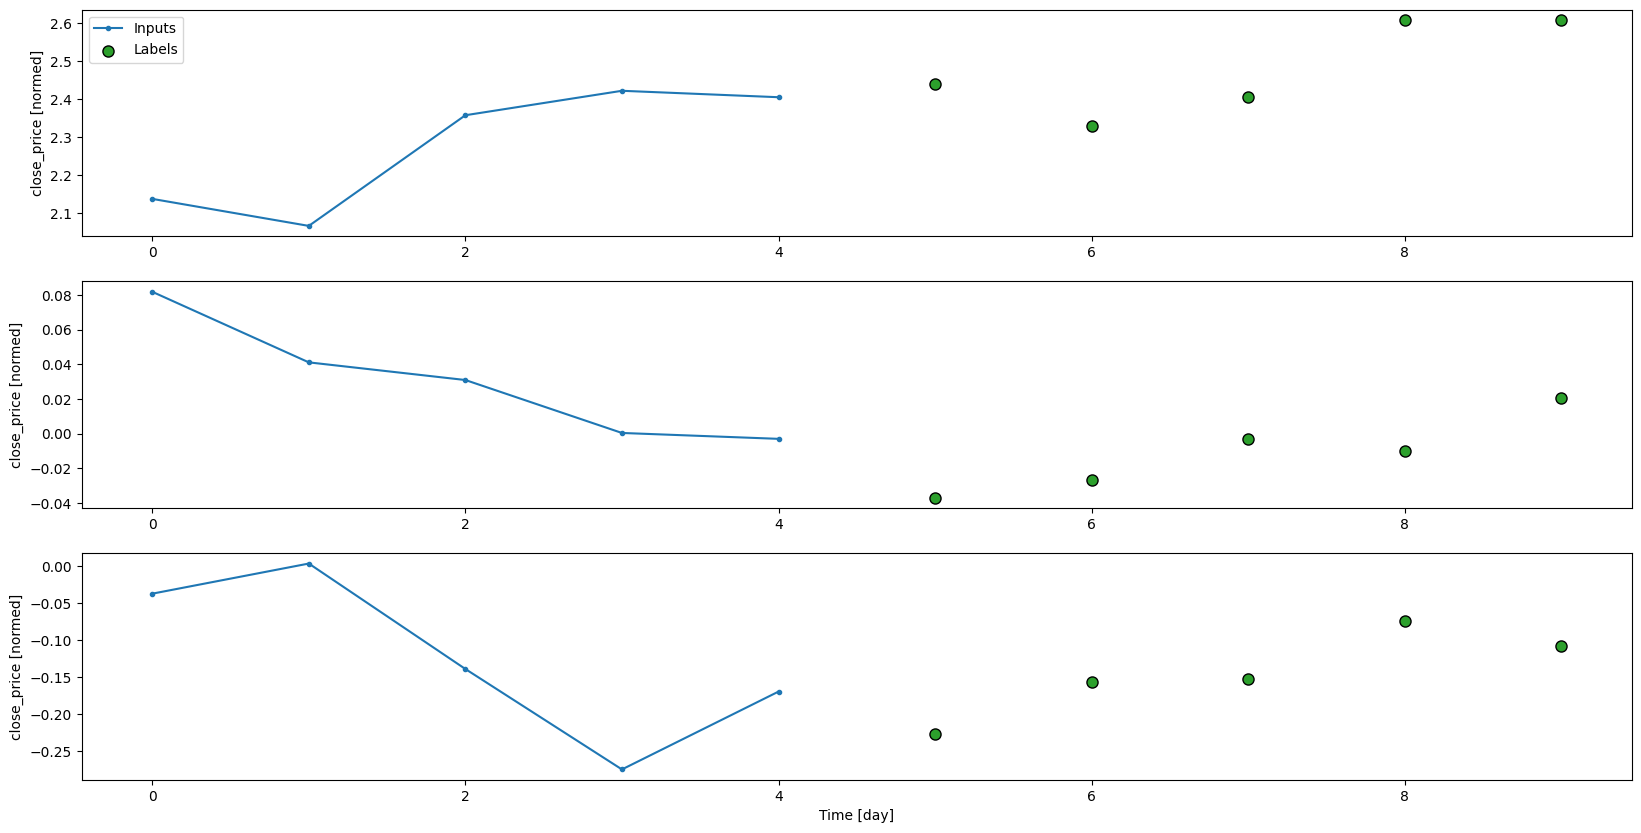

In [458]:
multi_window.plot()

Create dataset

In [459]:
def make_dataset(self, data): #data lấy liên tục 
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,#to avoid sequence bias
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [460]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [461]:
for inputs, labels in multi_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Labels shape (batch, time, features): {labels.shape}')

Inputs shape (batch, time, features): (32, 5, 12)
Labels shape (batch, time, features): (32, 5, 1)


In [462]:
multi_window.train

<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 12), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None))>

Build and Train model

In [463]:
tf.keras.backend.clear_session()
MAX_EPOCHS = 200

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def compile_and_fit(model, window, patience=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    # Set the learning rate scheduler
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

        
    model.compile(#loss=tf.keras.losses.MeanSquaredError()
                  loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(),
                         tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping,lr_schedule],verbose=1)
    return history

In [464]:
def plot_train (history):
    # list all data in history
    print(history.history.keys())

    # summarize history for loss

    fig, ax = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

Simple CNN

In [465]:
CONV_WIDTH =3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

2/2 [==============================] - 0s 3ms/step - loss: 0.0215 - mean_absolute_error: 0.1836 - root_mean_squared_error: 0.2072
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


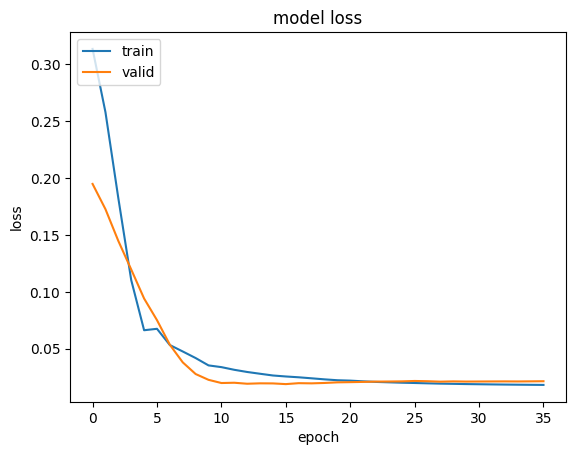

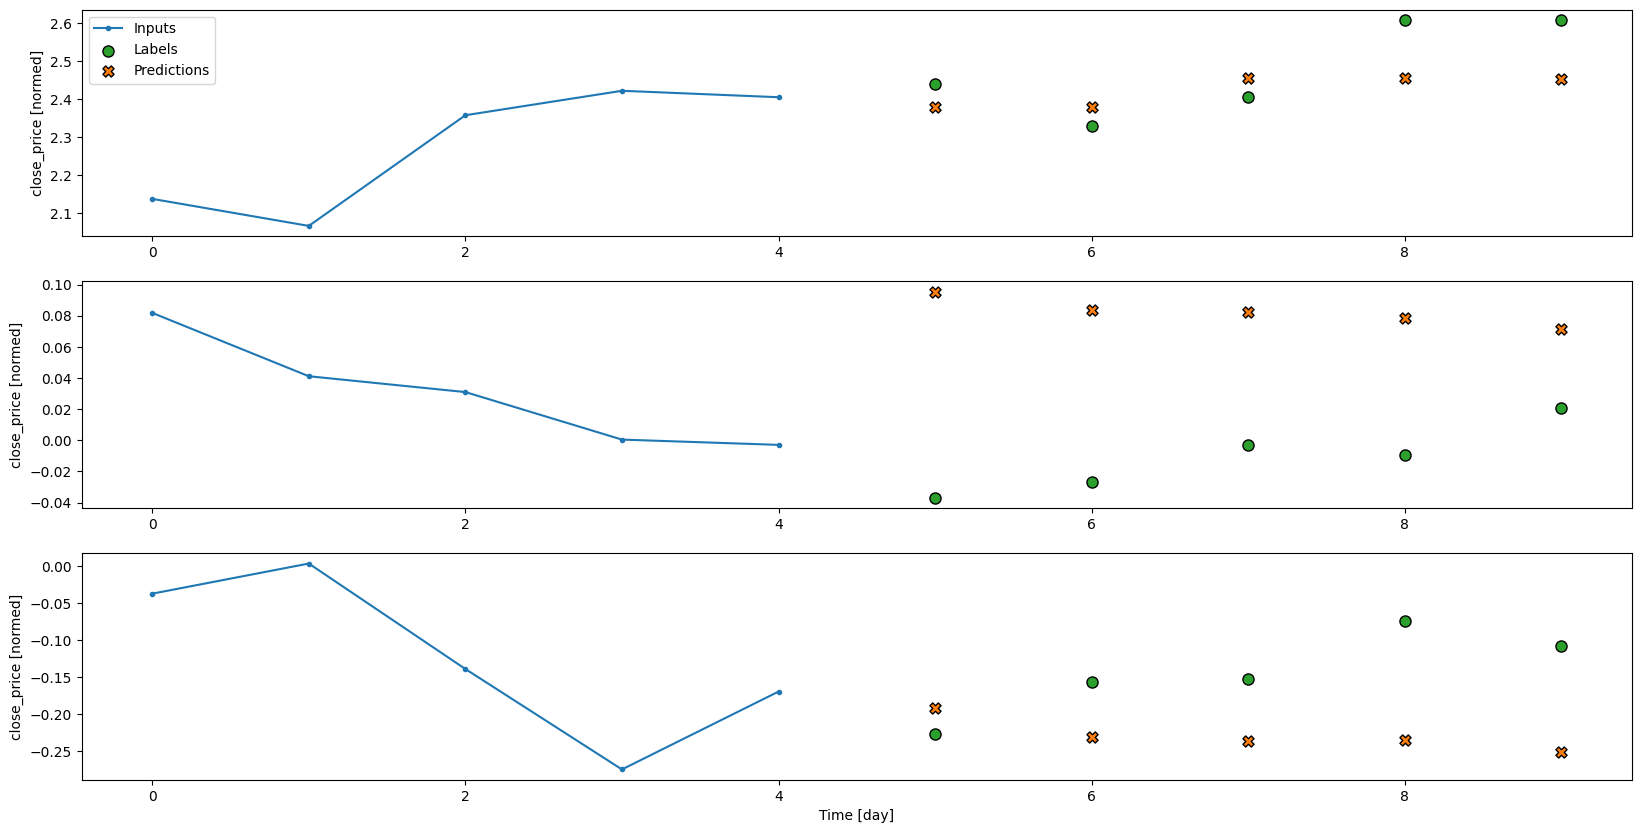

In [466]:
multi_conv_history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance = {}
multi_performance = {}

IPython.display.clear_output()

multi_val_performance['Simple Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Simple Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
plot_train(multi_conv_history)
multi_window.plot(multi_conv_model)

Transformer model

In [467]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [468]:
def build_transformer_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    for dim in mlp_units:
        x = tf.keras.layers.Dense(dim, activation="relu")(x)
        x = tf.keras.layers.Dropout(mlp_dropout)(x)
    x = tf.keras.layers.Dense(OUT_STEPS*num_features)(x)
    outputs = tf.keras.layers.Reshape([OUT_STEPS, num_features])(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model


input_shape = (input_width,num_features)
transformer_model = build_transformer_model(    
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,)

transformer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 12)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 5, 12)       24          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 5, 12)       52236       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

2/2 [==============================] - 0s 5ms/step - loss: 0.0816 - mean_absolute_error: 0.3626 - root_mean_squared_error: 0.4041
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


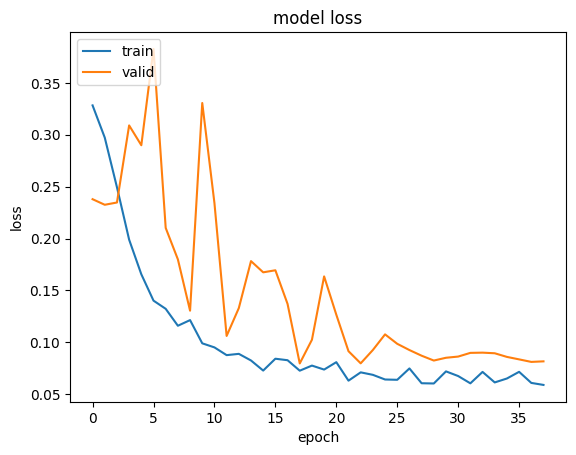

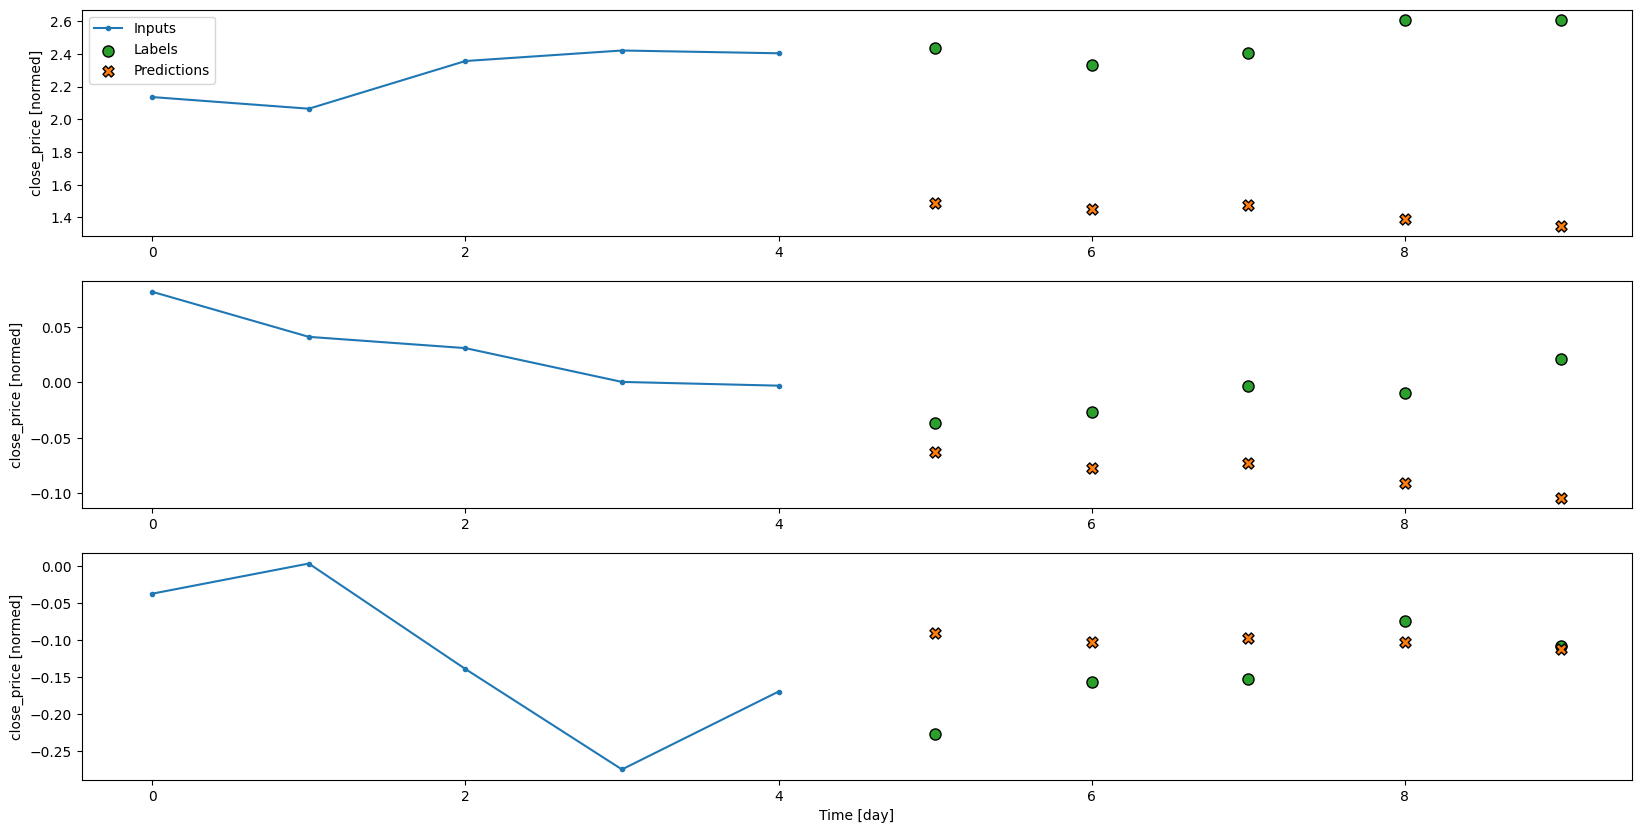

In [469]:
transformer_history = compile_and_fit(transformer_model, multi_window)

# multi_val_performance = {}
# multi_performance = {}

IPython.display.clear_output()

multi_val_performance['Transformer'] = transformer_model.evaluate(multi_window.val)
multi_performance['Transformer'] = transformer_model.evaluate(multi_window.test, verbose=0)
plot_train(transformer_history)
multi_window.plot(transformer_model)

Resnet + Transformer

In [470]:
# Define the ResNet model
def create_resnet_block(x, filters, kernel_size):
    shortcut = x

    x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    shortcut = tf.keras.layers.Conv1D(filters, 1, padding='same')(shortcut)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)

    return x

def create_resnet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = create_resnet_block(inputs, 64, 3)
    x = create_resnet_block(x, 128, 3)
    return tf.keras.Model(inputs, x)

# Define the Transformer block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim)]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    


In [471]:
# Combine the ResNet and Transformer
def build_resnet_transformer_model(input_shape, transformer_units, num_heads, ff_dim):
    resnet_model = create_resnet(input_shape)

    inputs = tf.keras.Input(shape=input_shape)
    resnet_output = resnet_model(inputs)
    x = Dense(transformer_units)(resnet_output)
    x = tf.reshape(x, (-1, input_shape[0], transformer_units))

    x = TransformerBlock(transformer_units, num_heads, ff_dim)(x)
    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(OUT_STEPS*num_features)(x)
    outputs = tf.keras.layers.Reshape([OUT_STEPS, num_features])(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# Set the required parameters
input_shape = (input_width,num_features)
transformer_units = 64
num_heads = 4
ff_dim = 64

# Create the combined model
resnet_transformer_model = build_resnet_transformer_model(input_shape, transformer_units, num_heads, ff_dim)
resnet_transformer_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 12)]           0         
                                                                 
 model_1 (Functional)        (None, 5, 128)            100160    
                                                                 
 dense_3 (Dense)             (None, 5, 64)             8256      
                                                                 
 tf.reshape (TFOpLambda)     (None, 5, 64)             0         
                                                                 
 transformer_block (Transfor  (None, 5, 64)            74944     
 merBlock)                                                       
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                           

2/2 [==============================] - 0s 3ms/step - loss: 0.0268 - mean_absolute_error: 0.1841 - root_mean_squared_error: 0.2314
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


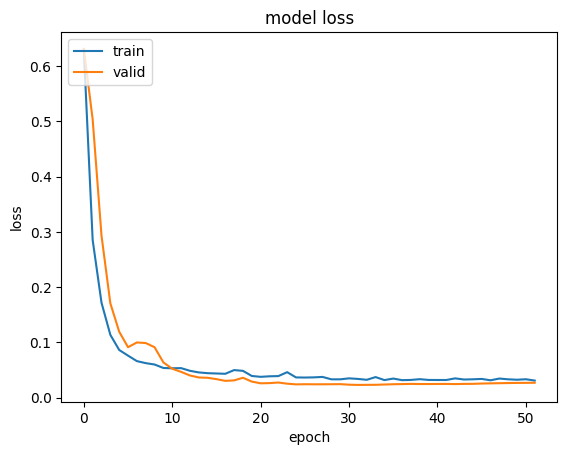

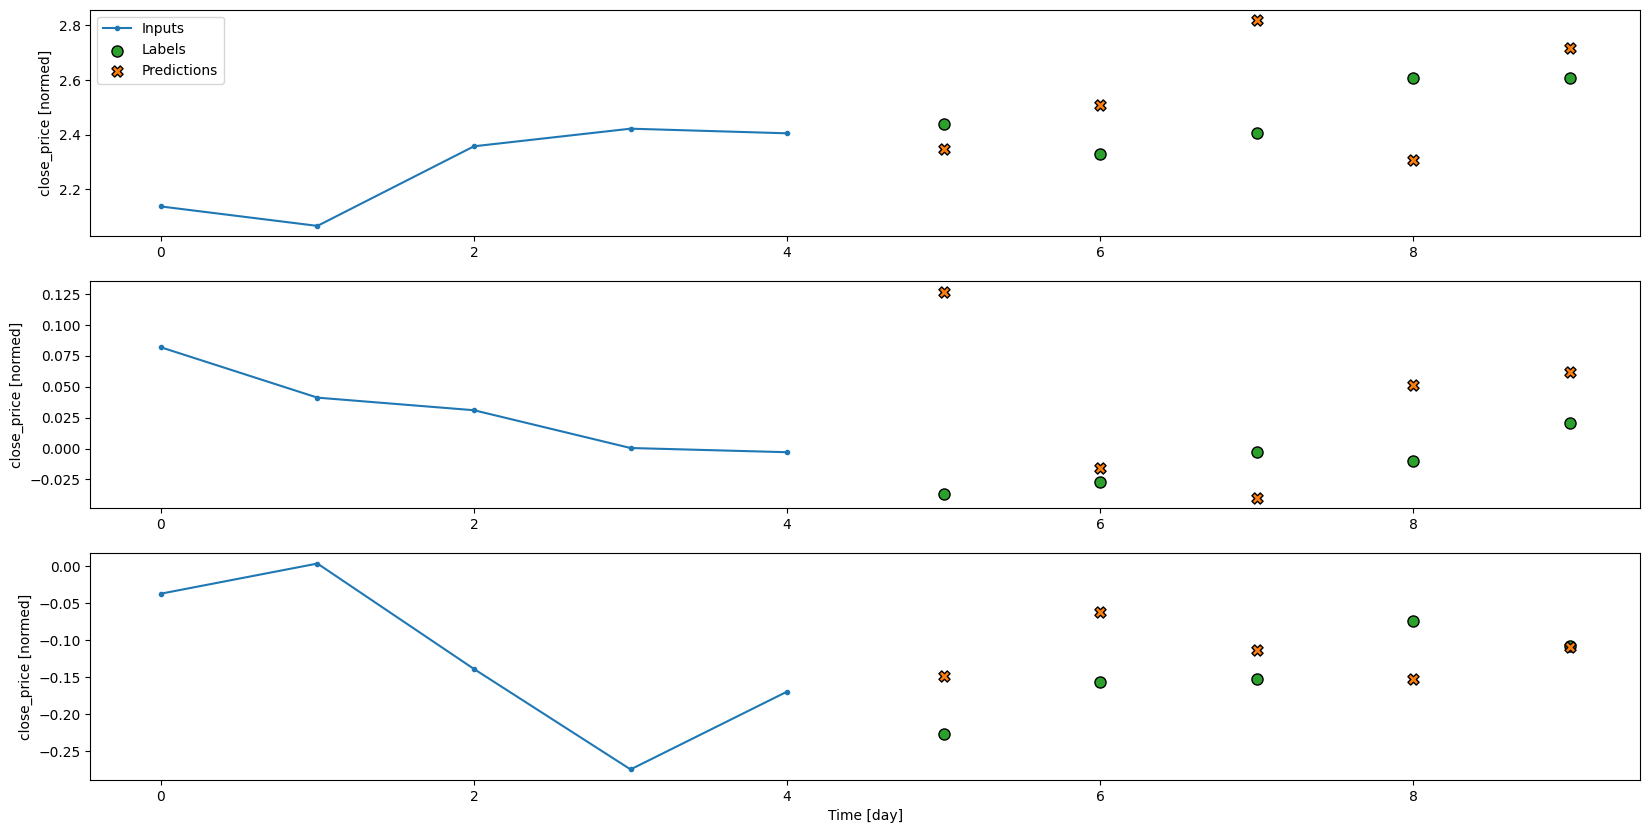

In [472]:
resnet_transformer_history = compile_and_fit(resnet_transformer_model, multi_window)

# multi_val_performance = {}
# multi_performance = {}

IPython.display.clear_output()

multi_val_performance['resnet_transformer_model'] = resnet_transformer_model.evaluate(multi_window.val)
multi_performance['resnet_transformer_model'] = resnet_transformer_model.evaluate(multi_window.test, verbose=0)
plot_train(resnet_transformer_history)
multi_window.plot(resnet_transformer_model)

# RESULT 

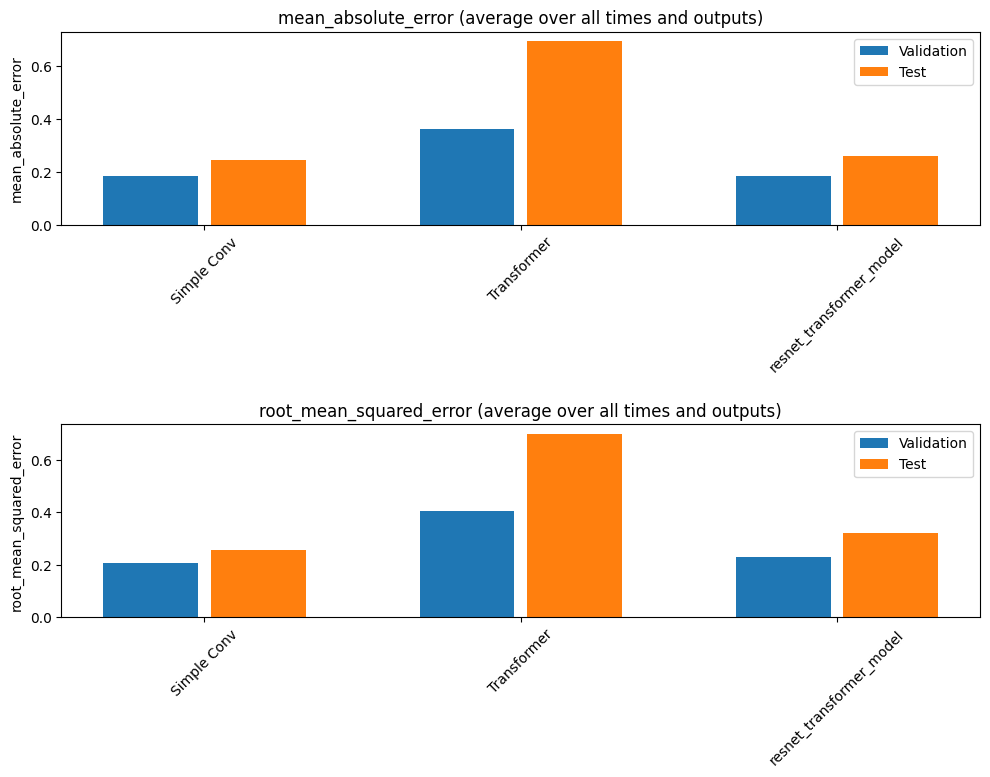

In [473]:
x = np.arange(len(multi_performance))
width = 0.3

plt.figure(figsize=(10, 8))
plt.subplots_adjust(top=1.25, bottom=1.2)

metric_name = multi_conv_model.metrics_names[1:] #we don't draw loss
for i, name in enumerate(metric_name,1):
    plt.subplot(2, 1, i)
    
    metric_index = multi_conv_model.metrics_names.index(name)
    val_mae = [v[metric_index] for v in multi_val_performance.values()]
    test_mae = [v[metric_index] for v in multi_performance.values()]

    plt.bar(x - 0.17, val_mae, width, label='Validation')
    plt.bar(x + 0.17, test_mae, width, label='Test')
    plt.title (f'{name} (average over all times and outputs)')
    plt.xticks(ticks=x, labels=multi_performance.keys(),
               rotation=45)
    plt.ylabel(f'{name}') #(average over all times and outputs)
    _ = plt.legend()
    
plt.tight_layout()

# INFERENCE

In [474]:
test_window = tf.stack([np.array(test_df[test_df.shape[0] - input_width: test_df.shape[0]])])


In [475]:
scaler = Numerical.named_steps['standard scaler']

Denormalize prediction

In [476]:
def denorm(inputs,scaler, num_cols = num_cols):
    denorm_array = []
    for input in inputs:
        denorm_input = scaler.inverse_transform(input[:,:len(num_cols)])
        denorm_array.append(denorm_input)
    denorm_array = np.array(denorm_array,dtype=float)    
    return denorm_array

In [477]:
def plot_inference_denorm(self, model=None, plot_col='close_price', max_subplots=1, inputs = test_window, model_name = "model"):
    
    
    denorm_inputs = denorm(inputs, scaler)
    # print (denorm_input[:, plot_col_index])
    plt.figure(figsize=(20, 7))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [denormed]')
        plt.plot(self.input_indices, denorm_inputs[n,:, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if model is not None:
            predictions = model(inputs)
            denormalized_predictions = denorm(predictions,scaler)

            plt.scatter(self.label_indices, denormalized_predictions[n, :, plot_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
            print (denormalized_predictions[n, :, plot_col_index])
            plt.title(model_name)
        if n == 0:
            plt.legend(loc='upper left')

    plt.xlabel('Time [day]')
    

WindowGenerator.plot_inference_denorm = plot_inference_denorm

All models

In [478]:
models = [multi_conv_model, transformer_model, resnet_transformer_model]

Simple Conv
[40.26063545 40.21910146 40.02698127 39.90507757 40.02584044]
Transformer
[49.37304732 49.20608343 49.09152569 48.77097147 48.84598332]
resnet_transformer_model
[46.31262179 46.97663475 43.66307215 31.74642254 31.04086504]


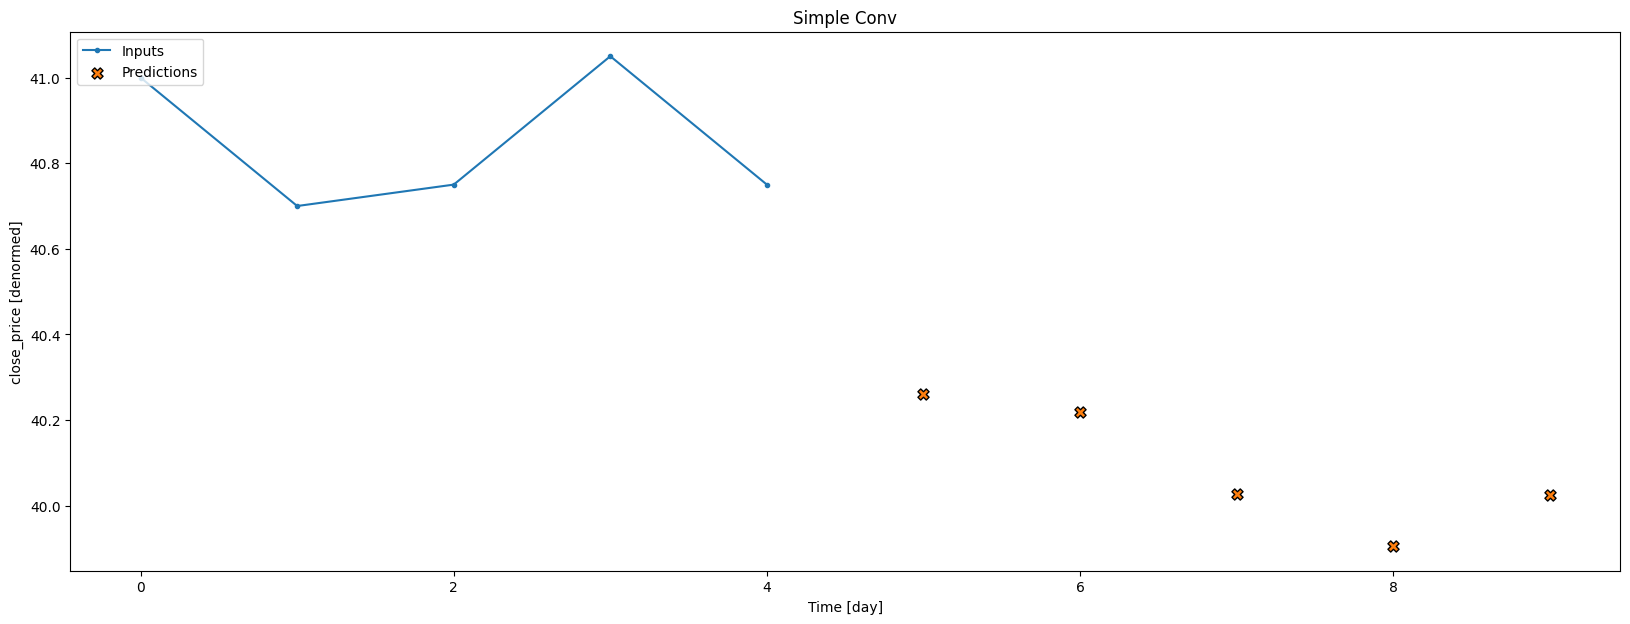

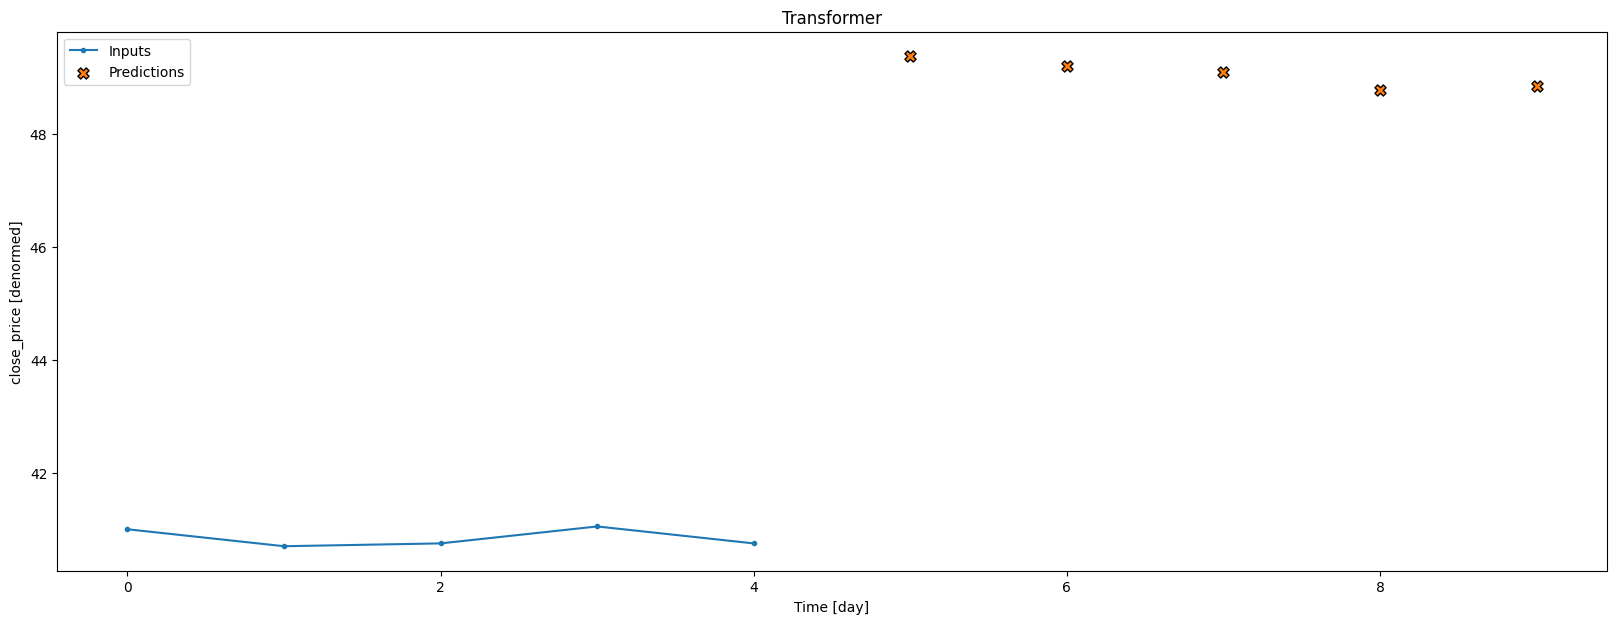

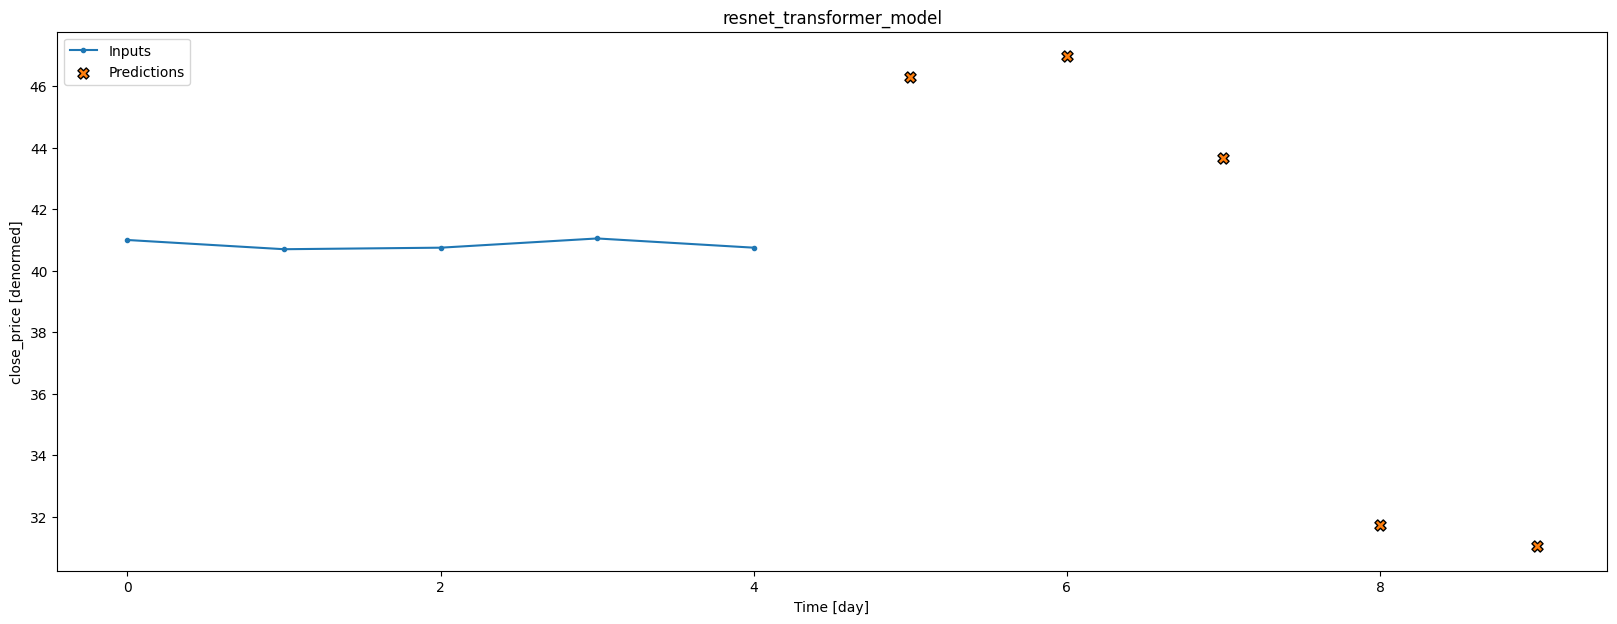

In [479]:
for model_name, model in zip(list(multi_performance.keys()), models):
    print (model_name)
    multi_window.plot_inference_denorm(model, model_name = model_name)

Feature importance

In [480]:
# Initialize empty lists for inputs and labels
all_inputs = []
all_labels = []

# Iterate over the dataset and append inputs and labels
for inputs, labels in multi_window.train:
    all_inputs.append(inputs.numpy())
    all_labels.append(labels.numpy())

# Convert the lists of inputs and labels to numpy arrays
all_inputs = np.concatenate(all_inputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Now, 'all_inputs' and 'all_labels' contain the entire dataset's inputs and labels


In [481]:
def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

def permutation_feature_importance(model, X, y_true):
    # Get the baseline performance of the model
    y_pred = model.predict(X, verbose = 0)
    baseline_mse = mean_squared_error(y_true, y_pred)

    # Initialize an array to store the importances
    feature_importances = np.zeros(X.shape[1])

    # Calculate the importance of each feature
    for i in range(X.shape[1]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, i])
        y_pred_permuted = model.predict(X_permuted)
        mse_permuted = mean_squared_error(y_true, y_pred_permuted)
        feature_importances[i] = baseline_mse - mse_permuted

    return feature_importances

In [482]:
def feature_impt (model,input = all_inputs, label = all_labels):
    # Calculate the feature importance
    feature_importances = permutation_feature_importance(model, all_inputs, all_labels)

    # Pair the feature importances with their names
    feature_importance_tuples = list(zip(train_df.columns, feature_importances))

    # Sort the feature importances from largest to smallest
    sorted_feature_importances = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)

    # # Print the sorted feature importances
    # for feature, importance in sorted_feature_importances:
    #     print(f"{feature}: {importance}")
    return sorted_feature_importances

5/5 [==============================] - 0s 1ms/step


C:\Users\baomc\AppData\Local\Temp\ipykernel_11396\1133872965.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(df.columns)


5/5 [==============================] - 0s 3ms/step


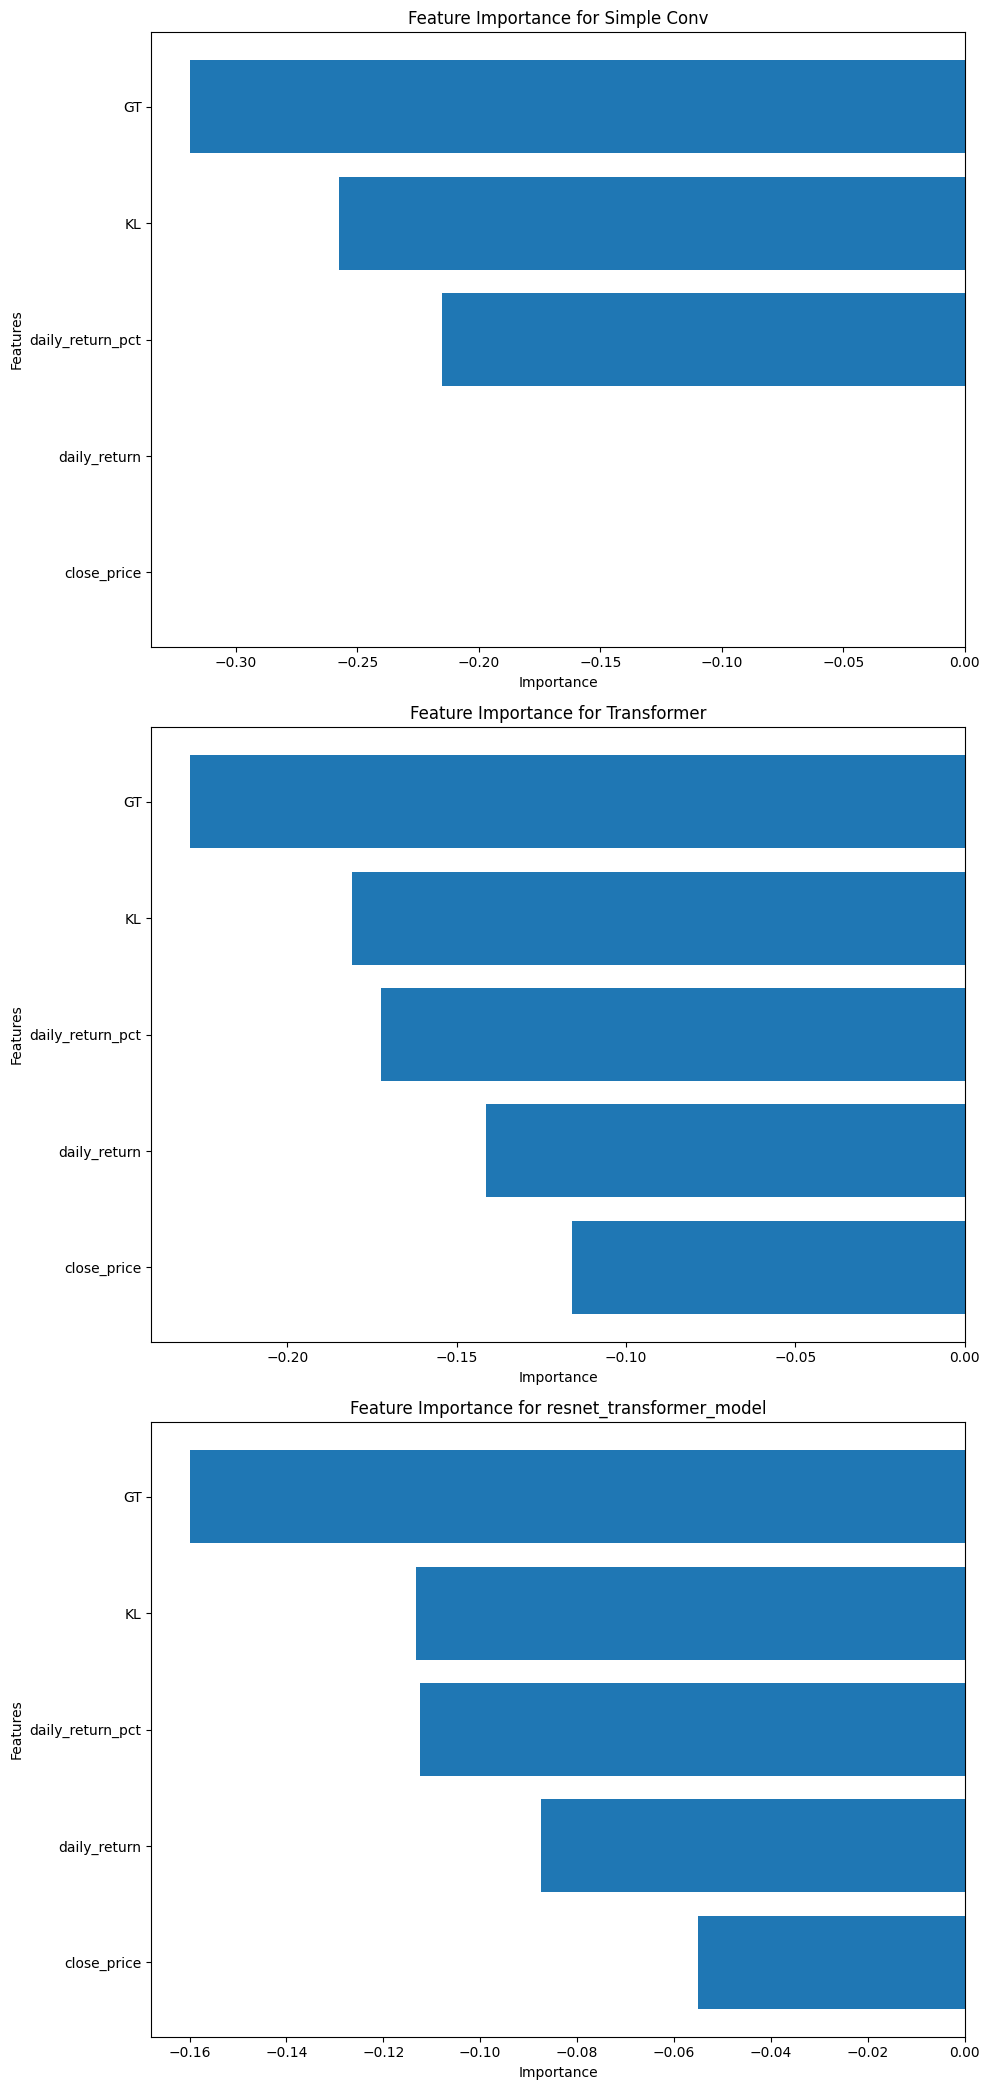

In [483]:
num_models = len(models)
fig, axs = plt.subplots(num_models, figsize=(10, 7 * num_models))

i = 0
for (model_name, model) in zip(list(multi_performance.keys()), models):
    # Calculate the feature importance for the current model
    sorted_feature_importances = feature_impt(model, all_inputs, all_labels)

    # Plot the sorted feature importances
    axs[i].barh([x[0] for x in sorted_feature_importances], [x[1] for x in sorted_feature_importances])
    axs[i].set_xlabel('Importance')
    axs[i].set_ylabel('Features')
    axs[i].set_title(f'Feature Importance for {model_name}')
    axs[i].set_yticklabels(df.columns)
    i += 1
plt.tight_layout()
plt.show()
